In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!ls




Mounted at /content/gdrive
gdrive	sample_data


In [4]:
data = pd.read_excel('/content/gdrive/MyDrive/tubes_pcd/dataset_apple.xlsx')

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import graycomatrix, graycoprops

# Load dataset
def load_data(filepath):
    data = pd.read_excel(filepath)
    if 'Unnamed: 0' in data.columns:
        data.drop(['Unnamed: 0'], axis=1, inplace=True)
    return data

# Perform correlation analysis
def plot_correlation(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')
    plt.show()

# Remove highly correlated or unnecessary features
def clean_data(data):
    features_to_drop = ['green_mean', 'red_std', 'blue_std', 'f5', 'f8', 'f1']
    return data.drop(features_to_drop, axis=1, inplace=False)

# Remove rows with null values
def remove_null_rows(data):
    return data.dropna()

# Extract GLCM features
def extract_glcm_features(image_array, distances=[1], angles=[0]):
    glcm = graycomatrix(image_array, distances=distances, angles=angles, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]

# Train and evaluate model
def train_and_evaluate_model(X, y):
    model = RandomForestClassifier(n_estimators=100, random_state=42)

    # K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f'Cross-Validation Accuracy Scores: {cv_scores}')
    print(f'Mean CV Accuracy: {np.mean(cv_scores) * 100:.2f}%')

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) == 2 else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Classification Metrics Plot
    class_names = list(classification_rep.keys())[:-3]  # Exclude avg/total rows
    precision = [classification_rep[name]['precision'] for name in class_names]
    recall = [classification_rep[name]['recall'] for name in class_names]
    f1_score = [classification_rep[name]['f1-score'] for name in class_names]
    x = np.arange(len(class_names))
    width = 0.25

    plt.figure(figsize=(8, 6))
    plt.bar(x - width, precision, width, label='Precision')
    plt.bar(x, recall, width, label='Recall')
    plt.bar(x + width, f1_score, width, label='F1 Score')
    plt.xticks(x, class_names)
    plt.title('Classification Metrics')
    plt.legend()
    plt.savefig('classification_metrics.png')
    plt.show()

    # Cross-Validation Scores Plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o')
    plt.title('K-Fold Cross Validation Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.savefig('cv_accuracy.png')
    plt.show()

    # ROC Curve Plot
    if y_prob is not None:  # Binary classification
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve.png')
        plt.show()

    return model



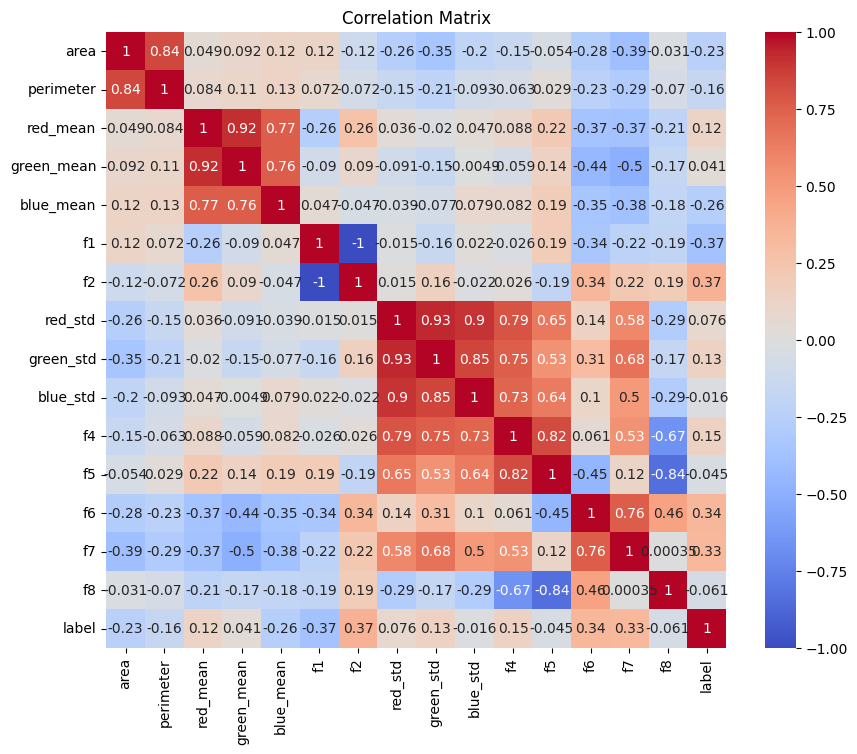

Cross-Validation Accuracy Scores: [0.86645161 0.85548387 0.86645161 0.86       0.84764364]
Mean CV Accuracy: 85.92%
Accuracy: 87.55%
Confusion Matrix:
[[376  22  19   8]
 [ 31 303  34  26]
 [ 24  14 356   0]
 [  5  10   0 322]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       425
           1       0.87      0.77      0.82       394
           2       0.87      0.90      0.89       394
           3       0.90      0.96      0.93       337

    accuracy                           0.88      1550
   macro avg       0.88      0.88      0.88      1550
weighted avg       0.88      0.88      0.87      1550



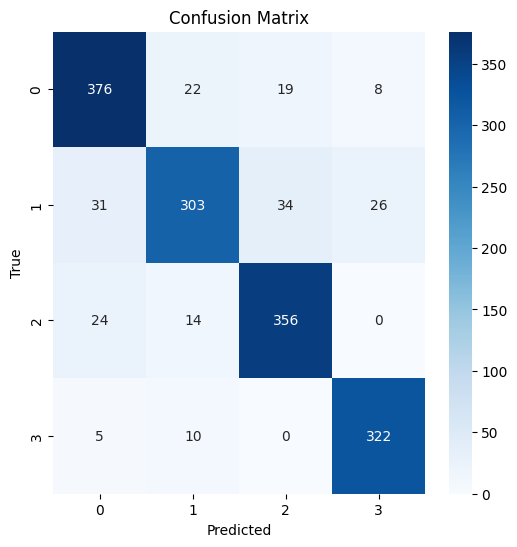

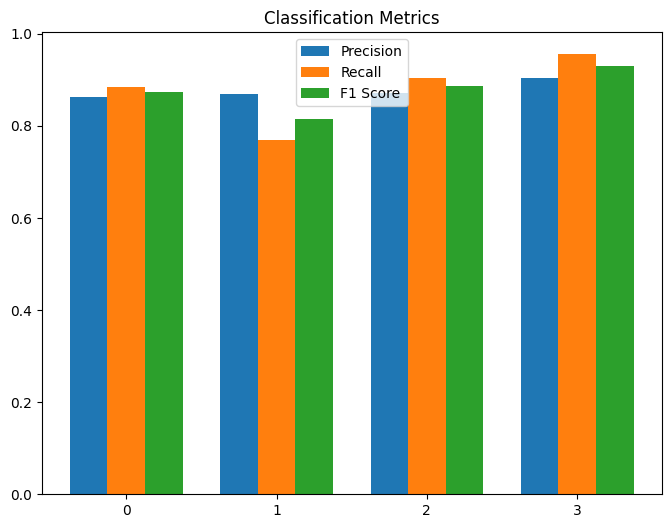

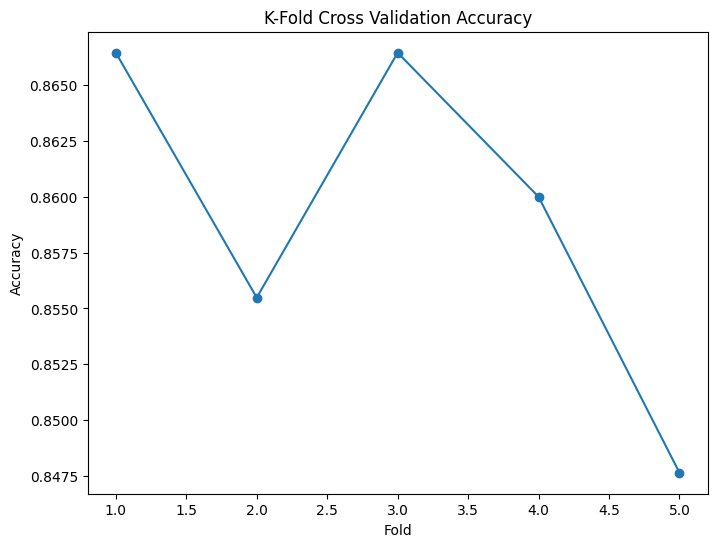

Model saved as random_forest_model.pkl


In [28]:
import joblib

# Main workflow
def main():
    # Load and preprocess data
    filepath = '/content/gdrive/MyDrive/tubes_pcd/dataset_apple.xlsx'  # Update this path as needed
    raw_data = load_data(filepath)
    plot_correlation(raw_data)

    cleaned_data = clean_data(raw_data)
    cleaned_data = remove_null_rows(cleaned_data)

    # Split data into features and target
    X = cleaned_data.iloc[:, :-1]
    y = cleaned_data.iloc[:, -1]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for dimensionality reduction (optional)
    pca = PCA(n_components=5)  # Adjust number of components as needed
    X_pca = pca.fit_transform(X_scaled)

    # Train and evaluate model
    model = train_and_evaluate_model(X_pca, y)

    # Save the trained model
    joblib.dump(model, 'random_forest_model.pkl')
    print("Model saved as random_forest_model.pkl")


if __name__ == '__main__':
    main()


In [29]:
# Load the saved model
loaded_model = joblib.load('random_forest_model.pkl')


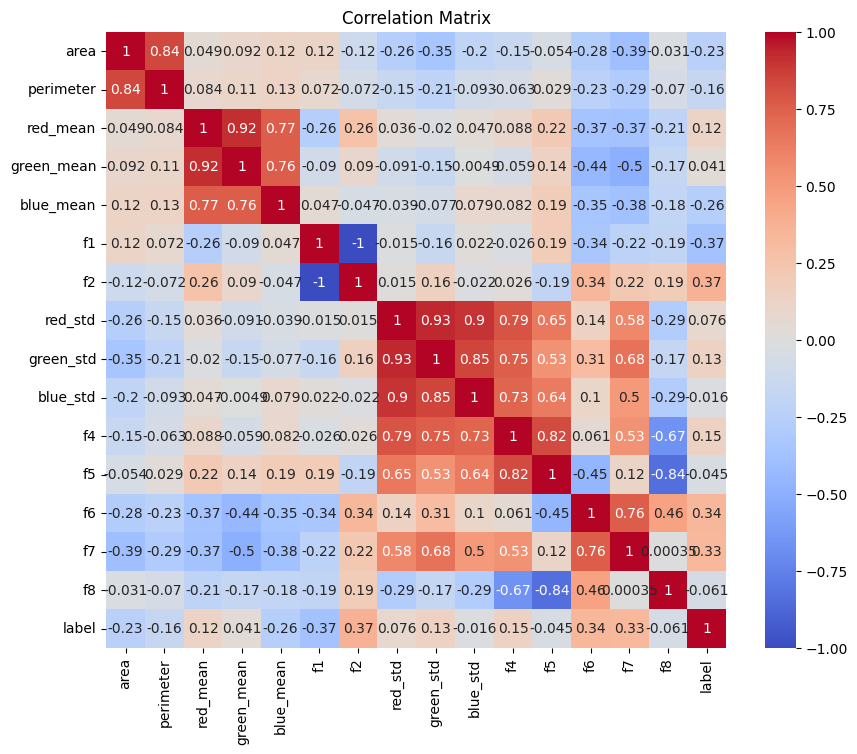

Loaded Model Accuracy: 97.51%


In [30]:
# Load the model
loaded_model = joblib.load('random_forest_model.pkl')

# Load and preprocess data
filepath = '/content/gdrive/MyDrive/tubes_pcd/dataset_apple.xlsx'  # Update this path as needed
raw_data = load_data(filepath)
plot_correlation(raw_data)

cleaned_data = clean_data(raw_data)
cleaned_data = remove_null_rows(cleaned_data)

# Split data into features and target
X = cleaned_data.iloc[:, :-1]
y = cleaned_data.iloc[:, -1]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for dimensionality reduction (optional)
pca = PCA(n_components=5)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Make predictions with the loaded model
y_loaded_pred = loaded_model.predict(X_pca)
print(f'Loaded Model Accuracy: {accuracy_score(y, y_loaded_pred) * 100:.2f}%')
